<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ViTPose/Inference_with_ViTPose_for_body_pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with ViTPose for body pose estimation

In this notebook, we'll perform inference with the [ViTPose](https://huggingface.co/docs/transformers/model_doc/vitpose) model which was just added in Transformers [v4.48](https://github.com/huggingface/transformers/releases/tag/v4.48.0). ViTPose is a minimal model for doing pose estimation, which is the task of detecting the position and orientation of a person or an object. This is typically done by estimating the position of hands, head, elbows, shoulders etc. in an image.

ViTPose is minimal in the sense that it just leverages a plain [Vision Transformer (ViT)](https://huggingface.co/docs/transformers/en/model_doc/vit) model as a backbone, and adds a minimal decoder head on top which converts the image embeddings into heatmaps, which can be converted into keypoints. The authors further improve it in their follow-up work [ViTPose++](https://arxiv.org/abs/2212.04246) where a mixture-of-experts (MoE) module is incorporated in the ViT backbone along with pre-training on more data, which further enhances the performance.

![vitpose-architecture](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/vitpose-architecture.png)

Resources:
* ViTPose paper: https://arxiv.org/abs/2204.12484
* VitPose++ paper: https://arxiv.org/abs/2212.04246v3
* ViTPose docs: https://huggingface.co/docs/transformers/model_doc/vitpose.

## Set-up environment

Let's start by installing our favorite library.

In [1]:
!pip install --upgrade --q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 66.0 MB/s eta 0:00:00


## Load image

Let's load an image on which we'd like to estimate human poses.

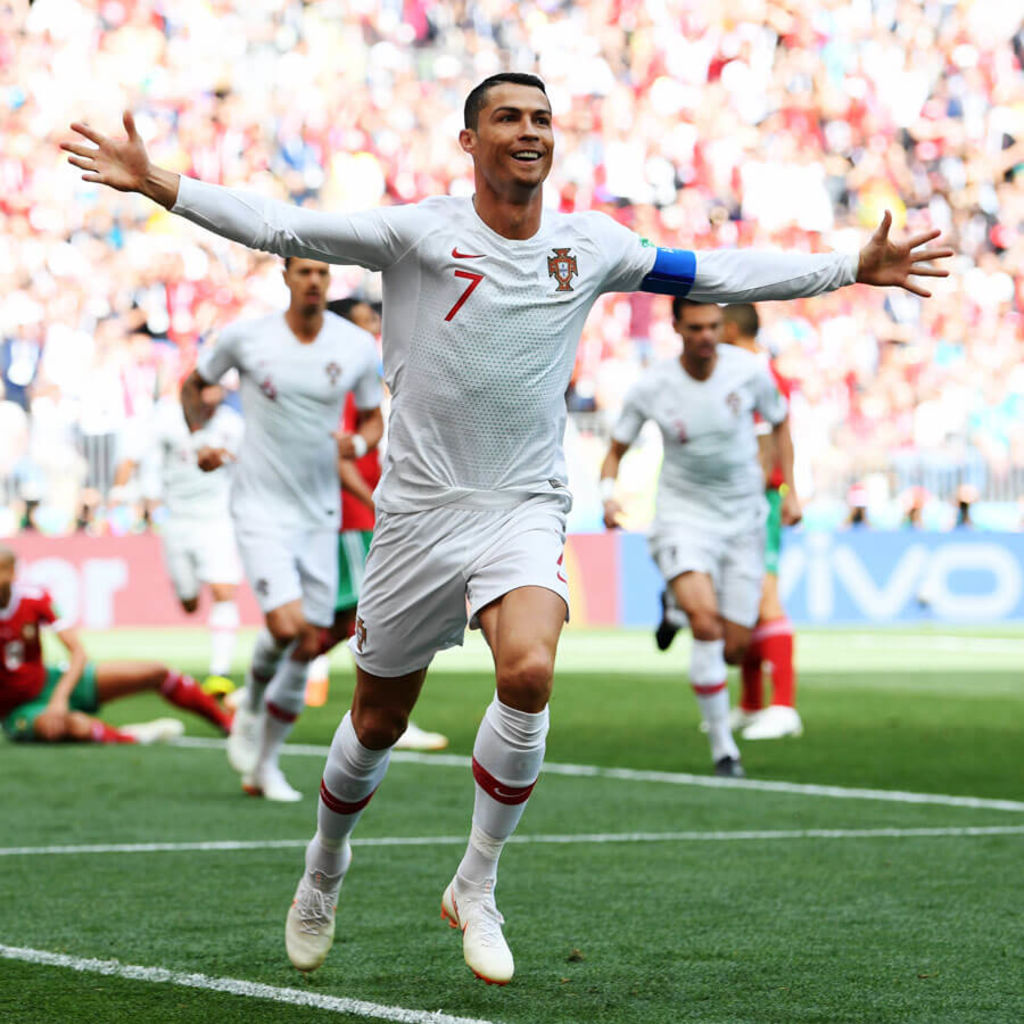

In [44]:
from PIL import Image
import requests

url = 'https://s3.amazonaws.com/mag.bleacherreport.com/cristiano-ronaldo-steve-nash-power-50-cover-2018/assets/8bb5c09194c9b2bcfa64365cb9245170/assets/image-1247-small-1024.jpg'
image = Image.open(requests.get(url, stream=True).raw)
display(image)

## Detect people/animals (in Pascal VOC format)

Note: ViTPose follows a so-called top-down approach for body pose estimation, which means that it relies on a separate object detection model which first detects persons/animals in an image. We then need to crop the detections out of the image and ViTPose will detect the poses for each person/animal individually.

Any object detector can be used (as long as it can detect people in an image). Here we employ the [RT-DETR](https://huggingface.co/docs/transformers/v4.48.0/en/model_doc/rt_detr) model available in the Transformers library. It has YOLO-like performance, but can also be used commercially as it has an Apache 2.0 license.

In [45]:
from transformers import AutoProcessor, RTDetrForObjectDetection
import torch

# use GPU if available - will speed up computations
device = "cuda" if torch.cuda.is_available() else "cpu"

person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device)

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

# forward pass
with torch.no_grad():
    outputs = person_model(**inputs)

In [47]:
# postprocess the output logits
results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]  # take first image results

# We filter the bounding boxes only for those that have predicted label index 0
# This is because index 0 refers to "person" in the COCO dataset
person_boxes_xyxy = result["boxes"][result["labels"] == 0]
person_boxes_xyxy = person_boxes_xyxy.cpu().numpy()

Let's visualize the cropped images!

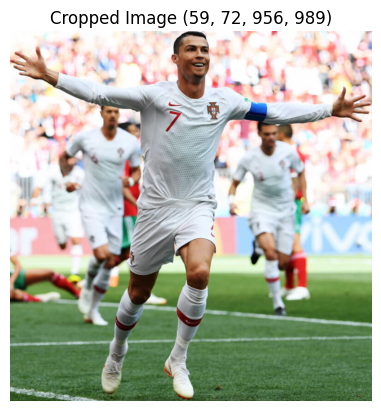

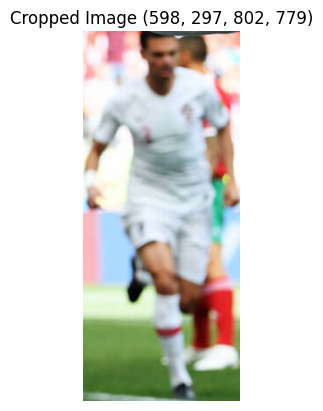

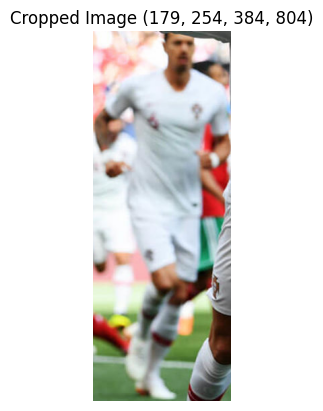

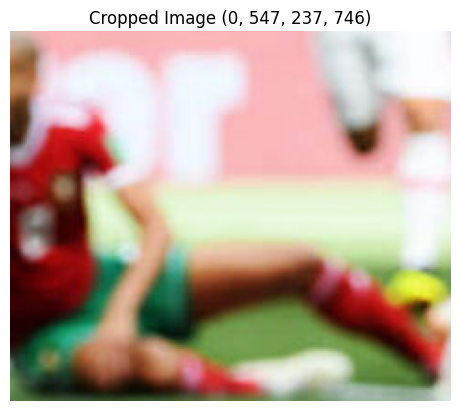

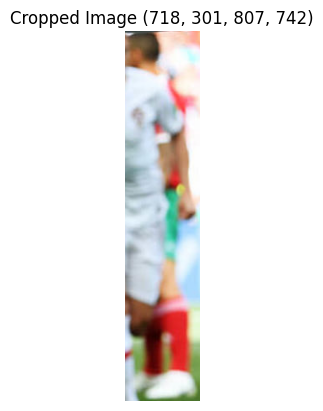

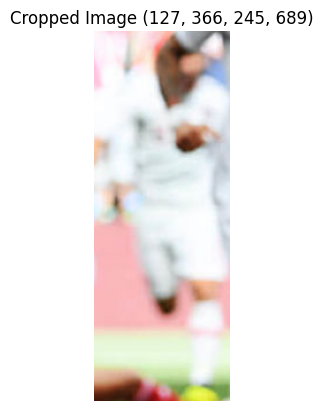

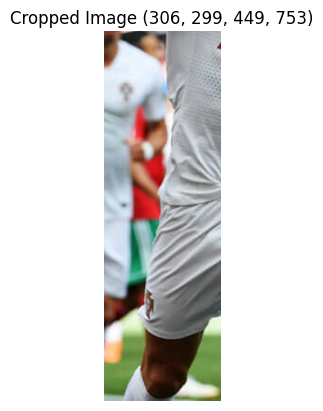

In [48]:
import matplotlib.pyplot as plt

for box in person_boxes_xyxy:
    xmin, ymin, xmax, ymax = box.astype(int)
    cropped_image = image.crop((xmin, ymin, xmax, ymax))
    plt.figure()
    plt.imshow(cropped_image)
    plt.title(f"Cropped Image ({xmin}, {ymin}, {xmax}, {ymax})")
    plt.axis('off')
    plt.show()

Great, let's take the first detected image (of Cristiano Ronaldo) so now we can forward this image through the ViTPose model. The ViTPose image processor expects the bounding boxes to be in COCO format, so we convert the boxes (which are currently in Pascal VOC format, namely top-left, bottom-right) into the COCO format.

In [52]:
person_boxes_xyxy[0]

array([ 59.987854,  72.80145 , 956.10925 , 989.8554  ], dtype=float32)

In [53]:
# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes_coco = np.expand_dims(person_boxes_xyxy[0].copy(), axis=0)
person_boxes_coco[:, 2] = person_boxes_coco[:, 2] - person_boxes_coco[:, 0]
person_boxes_coco[:, 3] = person_boxes_coco[:, 3] - person_boxes_coco[:, 1]

## Load ViTPose model

Next, it's time to load the ViTPose model! Note that the authors released a huge amount of weights, it's recommended to load one of the "vitpose-plus" weights as those are trained on the most data and hence have the best performance. Plus models are available in the "small", "base", "large" and "huge" variants. Larger variants result in better performance, but are also more computationally heavy.

In [74]:
from transformers import VitPoseForPoseEstimation

image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-large")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-plus-large", device_map=device)

OSError: usyd-community/vitpose-plus-large is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [75]:
model.config.id2label

{0: 'Nose',
 1: 'L_Eye',
 2: 'R_Eye',
 3: 'L_Ear',
 4: 'R_Ear',
 5: 'L_Shoulder',
 6: 'R_Shoulder',
 7: 'L_Elbow',
 8: 'R_Elbow',
 9: 'L_Wrist',
 10: 'R_Wrist',
 11: 'L_Hip',
 12: 'R_Hip',
 13: 'L_Knee',
 14: 'R_Knee',
 15: 'L_Ankle',
 16: 'R_Ankle'}

## Prepare image for the model

We can crop the image using the processor.

In [76]:
pixel_values = image_processor(image, boxes=[person_boxes_coco], return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 256, 192])


(fun fact) You can always visualize what the processor actually prepares for the model by "denormalizing" the pixel values back into RGB space. As can be seen, a lot of padding is applied to the image.

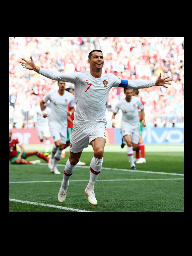

In [77]:
from PIL import Image
import numpy as np

mean = image_processor.image_mean
std = image_processor.image_std

batch_index = 0

unnormalized_image = (pixel_values[batch_index].numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

## Forward pass

Next we can forward the pixel values through the model! The plus variants also expect a so-called dataset index as the models were trained on various datasets of different domains, and the model uses an [Mixture-of-Experts (MoE)](https://huggingface.co/blog/moe) architecture, where the different experts were trained on the different domains. By selecting an index, only the respective expert MLP layer will be used.

The ViTPose++ models use 6 experts, the indices of the datasets are explained in the documentation. It's recommended to select the index of the dataset that best resembles your domain.

In [78]:
dataset_index = torch.tensor([0], device=device)

with torch.no_grad():
    # forward pass (no flip augmentation here)
    # note: the original implementation evaluates on both an original and flipped version of the image
    # and then averages the results
    outputs = model(pixel_values, dataset_index=dataset_index)

## Postprocess

Next, we use the image processor's post_process_pose_estimation method to turn the predicted heatmaps into keypoints.

In [79]:
outputs.heatmaps.shape

torch.Size([1, 17, 64, 48])

In [80]:
pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes_coco])
image_pose_result = pose_results[0]  # results for first image

## Visualize

In [71]:
!pip install -q supervision

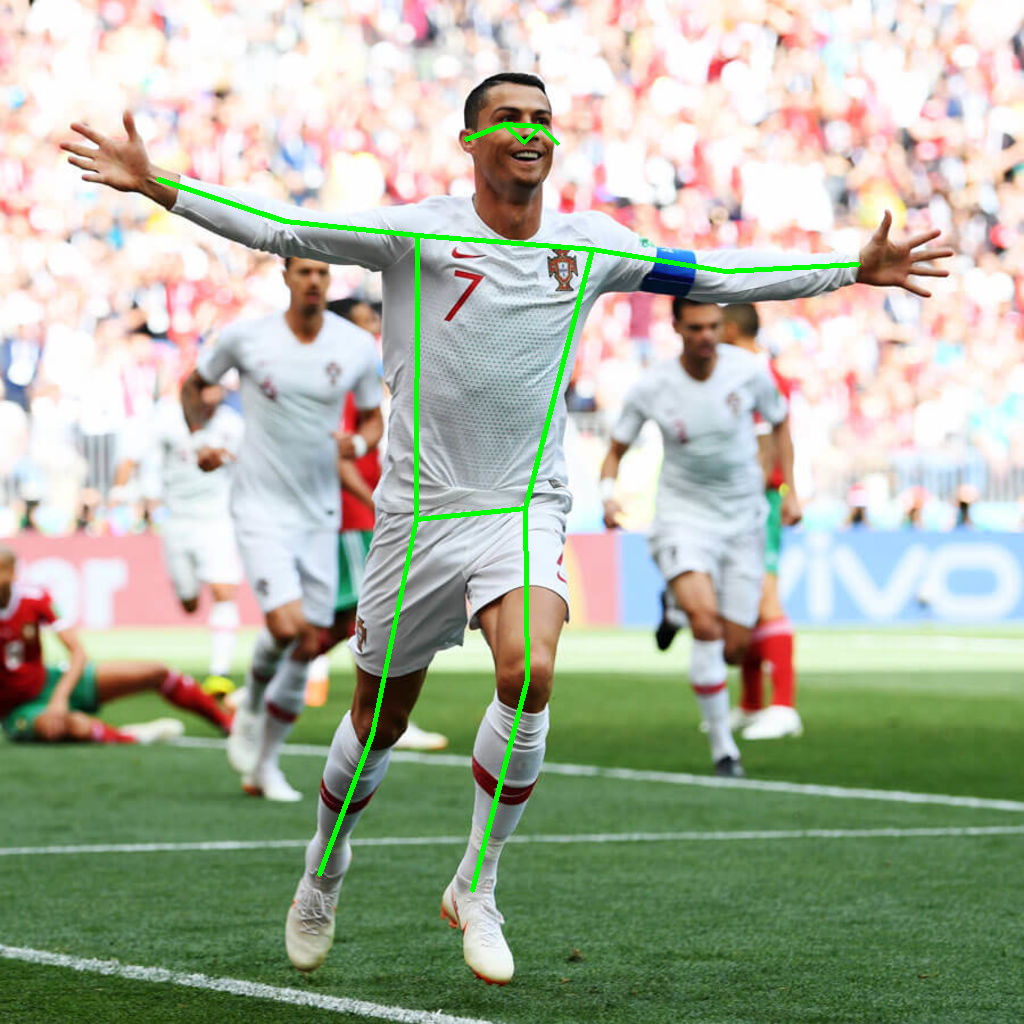

In [72]:
import supervision as sv

# make results more human-readable
human_readable_results = []
for i, person_pose in enumerate(image_pose_result):
    data = {
        "person_id": i,
        "bbox": person_pose["bbox"].numpy().tolist(),
        "keypoints": [],
    }
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"], strict=True
    ):
        keypoint_name = model.config.id2label[label.item()]
        x, y = keypoint
        data["keypoints"].append({"name": keypoint_name, "x": x.item(), "y": y.item(), "score": score.item()})
    human_readable_results.append(data)

# preprocess to torch tensor of shape (n_objects, n_keypoints, 2)
xy = [pose_result["keypoints"] for pose_result in image_pose_result]
xy = torch.stack(xy).cpu().numpy()

scores = [pose_result["scores"] for pose_result in image_pose_result]
scores = torch.stack(scores).cpu().numpy()

keypoints = sv.KeyPoints(xy=xy, confidence=scores)
detections = sv.Detections(xyxy=np.expand_dims(person_boxes_xyxy[0], axis=0))

edge_annotator = sv.EdgeAnnotator(color=sv.Color.GREEN, thickness=3)
vertex_annotator = sv.VertexAnnotator(color=sv.Color.RED, radius=2)
bounding_box_annotator = sv.BoxAnnotator(color=sv.Color.WHITE, color_lookup=sv.ColorLookup.INDEX, thickness=1)

annotated_frame = image.copy()

# optionally you can also annotate bounding boxes
# annotated_frame = bounding_box_annotator.annotate(scene=image.copy(), detections=detections)

# annotate edges and vertices
annotated_frame = edge_annotator.annotate(scene=annotated_frame, key_points=keypoints)
annotated_frame

## Next steps

As a next step, I would recommend the following things:
* one can optimize ViTPose in [ONNX](https://huggingface.co/docs/optimum/v1.2.1/en/onnxruntime/modeling_ort) using the 🤗 Optimum library for blazing fast inference
* one can apply ViTPose on a video, as shown in [this app](https://huggingface.co/spaces/hysts/ViTPose-transformers). Code is open-source, [here](https://huggingface.co/spaces/hysts/ViTPose-transformers/tree/main).